In [161]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path

In [162]:
# Define paths to the training datasets
no_watermark_path = "wm-nowm/train/no-watermark/"
watermark_path = "wm-nowm/train/watermark/"

# Get sample images (10 from each category)
no_wm_images = glob.glob(os.path.join(no_watermark_path, "*.jpeg"))[:10]
wm_images = glob.glob(os.path.join(watermark_path, "*.jpeg"))[:10]

print(f"Found {len(no_wm_images)} no-watermark sample images")
print(f"Found {len(wm_images)} watermark sample images")

Found 10 no-watermark sample images
Found 10 watermark sample images


In [163]:
def apply_canny_edge_detection(image_path, low_threshold=50, high_threshold=150):
    """
    Load an image and apply Canny edge detection
    """
    # Read the image
    img = cv2.imread(image_path)
    
    # Convert BGR to RGB for proper display with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 1.5)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, low_threshold, high_threshold)
    
    return img_rgb, edges

In [164]:
# Apply basic Canny edge detection to the 10 watermarked images
print("Applying basic Canny edge detection to 10 watermarked images...")
print("(Using fixed thresholds: low=50, high=150)\n")

basic_canny_results = []

for idx, img_path in enumerate(wm_images[:10]):
    img_rgb, edges = apply_canny_edge_detection(img_path, low_threshold=50, high_threshold=150)
    
    # Calculate edge density
    edge_density = (np.count_nonzero(edges) / edges.size) * 100
    
    basic_canny_results.append({
        'path': img_path,
        'filename': os.path.basename(img_path),
        'img_rgb': img_rgb,
        'edges': edges,
        'edge_density': edge_density
    })
    
    print(f"  {idx+1:2d}. {os.path.basename(img_path)[:50]:<50} → Edges: {edge_density:.2f}%")

print(f"\n✓ Processed {len(basic_canny_results)} images")
print(f"Average edge density: {np.mean([r['edge_density'] for r in basic_canny_results]):.2f}%")



Applying basic Canny edge detection to 10 watermarked images...
(Using fixed thresholds: low=50, high=150)

   1. pexels-photo-4228456.jpeg                          → Edges: 3.62%
   2. pexels-photo-442559.jpeg                           → Edges: 3.29%
   3. pexels-photo-4558495.jpeg                          → Edges: 7.87%
   4. pexels-photo-1085172.jpeg                          → Edges: 3.37%
   5. pexels-photo-1844897.jpeg                          → Edges: 11.30%
   6. pexels-photo-4840416.jpeg                          → Edges: 5.39%
   7. pexels-photo-1527009.jpeg                          → Edges: 2.92%
   8. pexels-photo-135492.jpeg                           → Edges: 2.51%
   9. sparrow-bird-animal-nature-86591.jpeg              → Edges: 5.70%
  10. pexels-photo-4492148.jpeg                          → Edges: 5.88%

✓ Processed 10 images
Average edge density: 5.18%


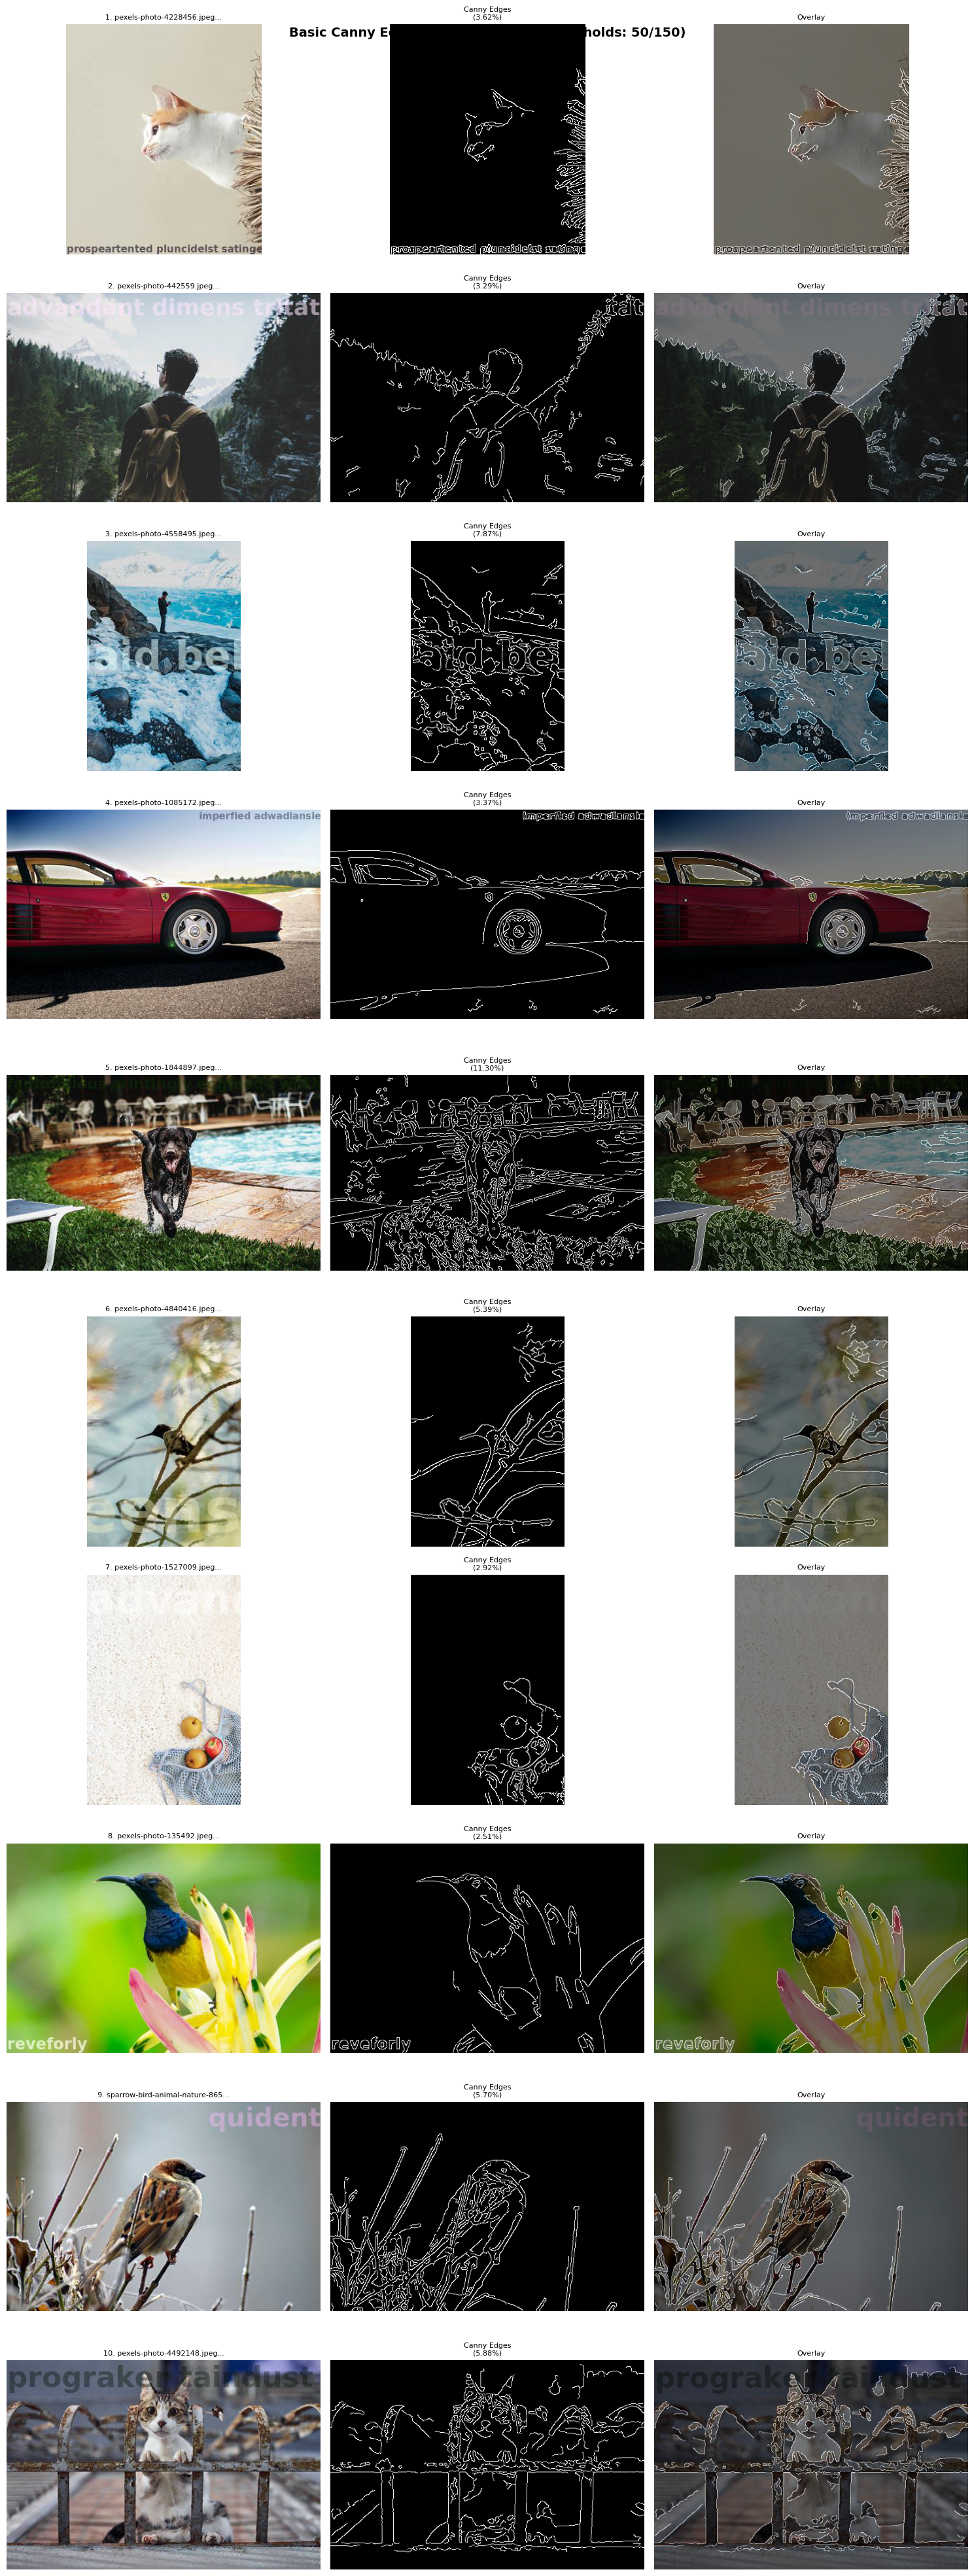


BASIC CANNY EDGE DETECTION SUMMARY
Image                                         Edge Density
--------------------------------------------------------------------------------
 1. pexels-photo-4228456.jpeg                      3.62%
 2. pexels-photo-442559.jpeg                       3.29%
 3. pexels-photo-4558495.jpeg                      7.87%
 4. pexels-photo-1085172.jpeg                      3.37%
 5. pexels-photo-1844897.jpeg                     11.30%
 6. pexels-photo-4840416.jpeg                      5.39%
 7. pexels-photo-1527009.jpeg                      2.92%
 8. pexels-photo-135492.jpeg                       2.51%
 9. sparrow-bird-animal-nature-86591.jpeg          5.70%
10. pexels-photo-4492148.jpeg                      5.88%
--------------------------------------------------------------------------------
AVERAGE                                          5.18%


In [165]:
# Visualize basic Canny edge detection on all 10 images
fig, axes = plt.subplots(10, 3, figsize=(15, 40))

for idx, result in enumerate(basic_canny_results):
    # Original image
    axes[idx, 0].imshow(result['img_rgb'])
    axes[idx, 0].set_title(f"{idx+1}. {result['filename'][:30]}...", fontsize=8)
    axes[idx, 0].axis('off')
    
    # Canny edges
    axes[idx, 1].imshow(result['edges'], cmap='gray')
    axes[idx, 1].set_title(f"Canny Edges\n({result['edge_density']:.2f}%)", fontsize=8)
    axes[idx, 1].axis('off')
    
    # Overlay
    axes[idx, 2].imshow(result['img_rgb'])
    axes[idx, 2].imshow(result['edges'], cmap='gray', alpha=0.5)
    axes[idx, 2].set_title("Overlay", fontsize=8)
    axes[idx, 2].axis('off')

plt.suptitle('Basic Canny Edge Detection (Fixed Thresholds: 50/150)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("BASIC CANNY EDGE DETECTION SUMMARY")
print("="*80)
print(f"{'Image':<45} {'Edge Density'}")
print("-"*80)

for i, result in enumerate(basic_canny_results, 1):
    print(f"{i:2d}. {result['filename'][:40]:<43} {result['edge_density']:>7.2f}%")

print("-"*80)
print(f"{'AVERAGE':<45} {np.mean([r['edge_density'] for r in basic_canny_results]):>7.2f}%")
print("="*80)



In [ ]:
def dual_threshold_watermark_detection(image_path, mid_thresh=60, high_thresh=150):
    """
    Detect watermarks using dual threshold approach.
    
    Theory: 
    - Strong edges (high threshold) = main image content
    - Medium edges (between mid and high) = likely watermarks
    
    Args:
        mid_thresh: Minimum edge strength (filters noise)
        high_thresh: Strong content edges threshold
    
    Returns:
        original image, strong edges, all edges, watermark edges
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 1.5)
    
    # Strong edges (main content)
    strong_edges = cv2.Canny(blurred, high_thresh, high_thresh * 2)
    
    # All significant edges (content + watermarks)
    all_edges = cv2.Canny(blurred, mid_thresh, high_thresh)
    
    # Isolate medium-strength edges (watermark candidates)
    watermark_edges = cv2.bitwise_and(all_edges, cv2.bitwise_not(strong_edges))
    
    # Apply morphological operations to clean up
    kernel = np.ones((2, 2), np.uint8)
    watermark_edges_cleaned = cv2.morphologyEx(watermark_edges, cv2.MORPH_CLOSE, kernel)
    
    return img_rgb, strong_edges, all_edges, watermark_edges_cleaned

print("✓ Dual-threshold watermark detection function defined")



## Adaptive Dual-Threshold Edge Detection

**Automatically calculates optimal thresholds for each image**

Instead of using fixed thresholds (50/150), this method:
1. Scans Canny at multiple thresholds (10-255)
2. Finds the "effective max" where edges stop appearing
3. Calculates `mid` and `high` thresholds as ratios of effective max
4. Applies dual-threshold detection with custom thresholds

**How Dual-Threshold Works:**
- Strong edges (high threshold) = main image content
- All edges (mid threshold) = content + watermarks
- Watermark edges = All - Strong (isolates watermarks)

Each image gets its own thresholds based on its characteristics!



In [166]:
def calculate_adaptive_thresholds(image_path):
    """
    Calculate adaptive thresholds using CANNY edge detection with max_ratio method.
    Returns TWO thresholds: mid (minimum edge strength) and high (strong edges).
    
    Args:
        image_path: Path to image
    
    Returns:
        mid_thresh, high_thresh
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(img, (5, 5), 1.5)
    
    # Find effective maximum threshold by scanning Canny
    test_range = range(10, 255, 5)
    max_edges_found = 0
    effective_max = 255
    
    for thresh in test_range:
        edges = cv2.Canny(blurred, thresh, thresh * 2)
        edge_count = np.count_nonzero(edges)
        
        if edge_count > max_edges_found:
            max_edges_found = edge_count
        
        # If edge count drops to near zero, we've found our effective max
        if edge_count < max_edges_found * 0.01:
            effective_max = thresh
            break
    
    # Set thresholds as ratios of the effective maximum
    MID_RATIO = 0.33
    HIGH_RATIO = 0.66
    
    mid_thresh = effective_max * MID_RATIO
    high_thresh = effective_max * HIGH_RATIO
    
    # Ensure thresholds are positive and in correct order
    mid_thresh = max(20, mid_thresh)
    high_thresh = max(mid_thresh + 30, high_thresh)
    
    return int(mid_thresh), int(high_thresh)

# Test on one image
test_img = sample_images[0]
print("Testing adaptive threshold calculation (max_ratio method)...")
print(f"\nImage: {os.path.basename(test_img)}")

mid, high = calculate_adaptive_thresholds(test_img)
print(f"\nCalculated thresholds: Mid={mid:3d}, High={high:3d}")
    
print("\n💡 How it works:")
print("   1. Scans Canny at multiple thresholds (10-255)")
print("   2. Finds 'effective max' where edges stop appearing")
print("   3. Mid  = 33% of effective max (medium edges)")
print("   4. High = 66% of effective max (strong edges only)")
print("   5. Watermark edges = edges between Mid and High")




Testing adaptive threshold calculation (max_ratio method)...

Image: pexels-photo-4228456.jpeg

Calculated thresholds: Mid= 24, High= 72

💡 How it works:
   1. Scans Canny at multiple thresholds (10-255)
   2. Finds 'effective max' where edges stop appearing
   3. Mid  = 33% of effective max (filters noise)
   4. High = 66% of effective max (strong edges only)
   5. Watermark edges = edges between Mid and High


In [167]:
# Apply adaptive thresholds to all 10 sample images
print("Applying adaptive dual-threshold detection to 10 sample images...")
print("(Each image gets custom thresholds based on Canny edge analysis)\n")

adaptive_results = []

for idx, img_path in enumerate(sample_images):
    # Calculate adaptive thresholds (returns mid, high)
    mid, high = calculate_adaptive_thresholds(img_path)
    
    # Apply detection with custom thresholds
    img_rgb, strong_edges, all_edges, watermark_edges = dual_threshold_watermark_detection(
        img_path, mid, high
    )
    
    # Calculate edge densities
    strong_density = (np.count_nonzero(strong_edges) / strong_edges.size) * 100
    all_density = (np.count_nonzero(all_edges) / all_edges.size) * 100
    watermark_density = (np.count_nonzero(watermark_edges) / watermark_edges.size) * 100
    
    adaptive_results.append({
        'path': img_path,
        'filename': os.path.basename(img_path),
        'img_rgb': img_rgb,
        'strong_edges': strong_edges,
        'all_edges': all_edges,
        'watermark_edges': watermark_edges,
        'strong_density': strong_density,
        'all_density': all_density,
        'watermark_density': watermark_density,
        'thresholds': (mid, high)
    })
    
    print(f"  {idx+1:2d}. {os.path.basename(img_path)[:40]:<40} → Mid={mid:3d}, High={high:3d}")

print(f"\n✓ Processed {len(adaptive_results)} images with adaptive thresholds")
print(f"\nAverage watermark edge density: {np.mean([r['watermark_density'] for r in adaptive_results]):.2f}%")



Applying adaptive dual-threshold detection to 10 sample images...
(Each image gets custom thresholds based on Canny edge analysis)

   1. pexels-photo-4228456.jpeg                → Mid= 24, High= 72
   2. pexels-photo-442559.jpeg                 → Mid= 23, High= 69
   3. pexels-photo-4558495.jpeg                → Mid= 24, High= 72
   4. pexels-photo-1085172.jpeg                → Mid= 25, High= 76
   5. pexels-photo-1844897.jpeg                → Mid= 25, High= 76
   6. pexels-photo-4840416.jpeg                → Mid= 25, High= 76
   7. pexels-photo-1527009.jpeg                → Mid= 20, High= 50
   8. pexels-photo-135492.jpeg                 → Mid= 25, High= 75
   9. sparrow-bird-animal-nature-86591.jpeg    → Mid= 25, High= 76
  10. pexels-photo-4492148.jpeg                → Mid= 20, High= 60

✓ Processed 10 images with adaptive thresholds

Average watermark edge density: 3.09%


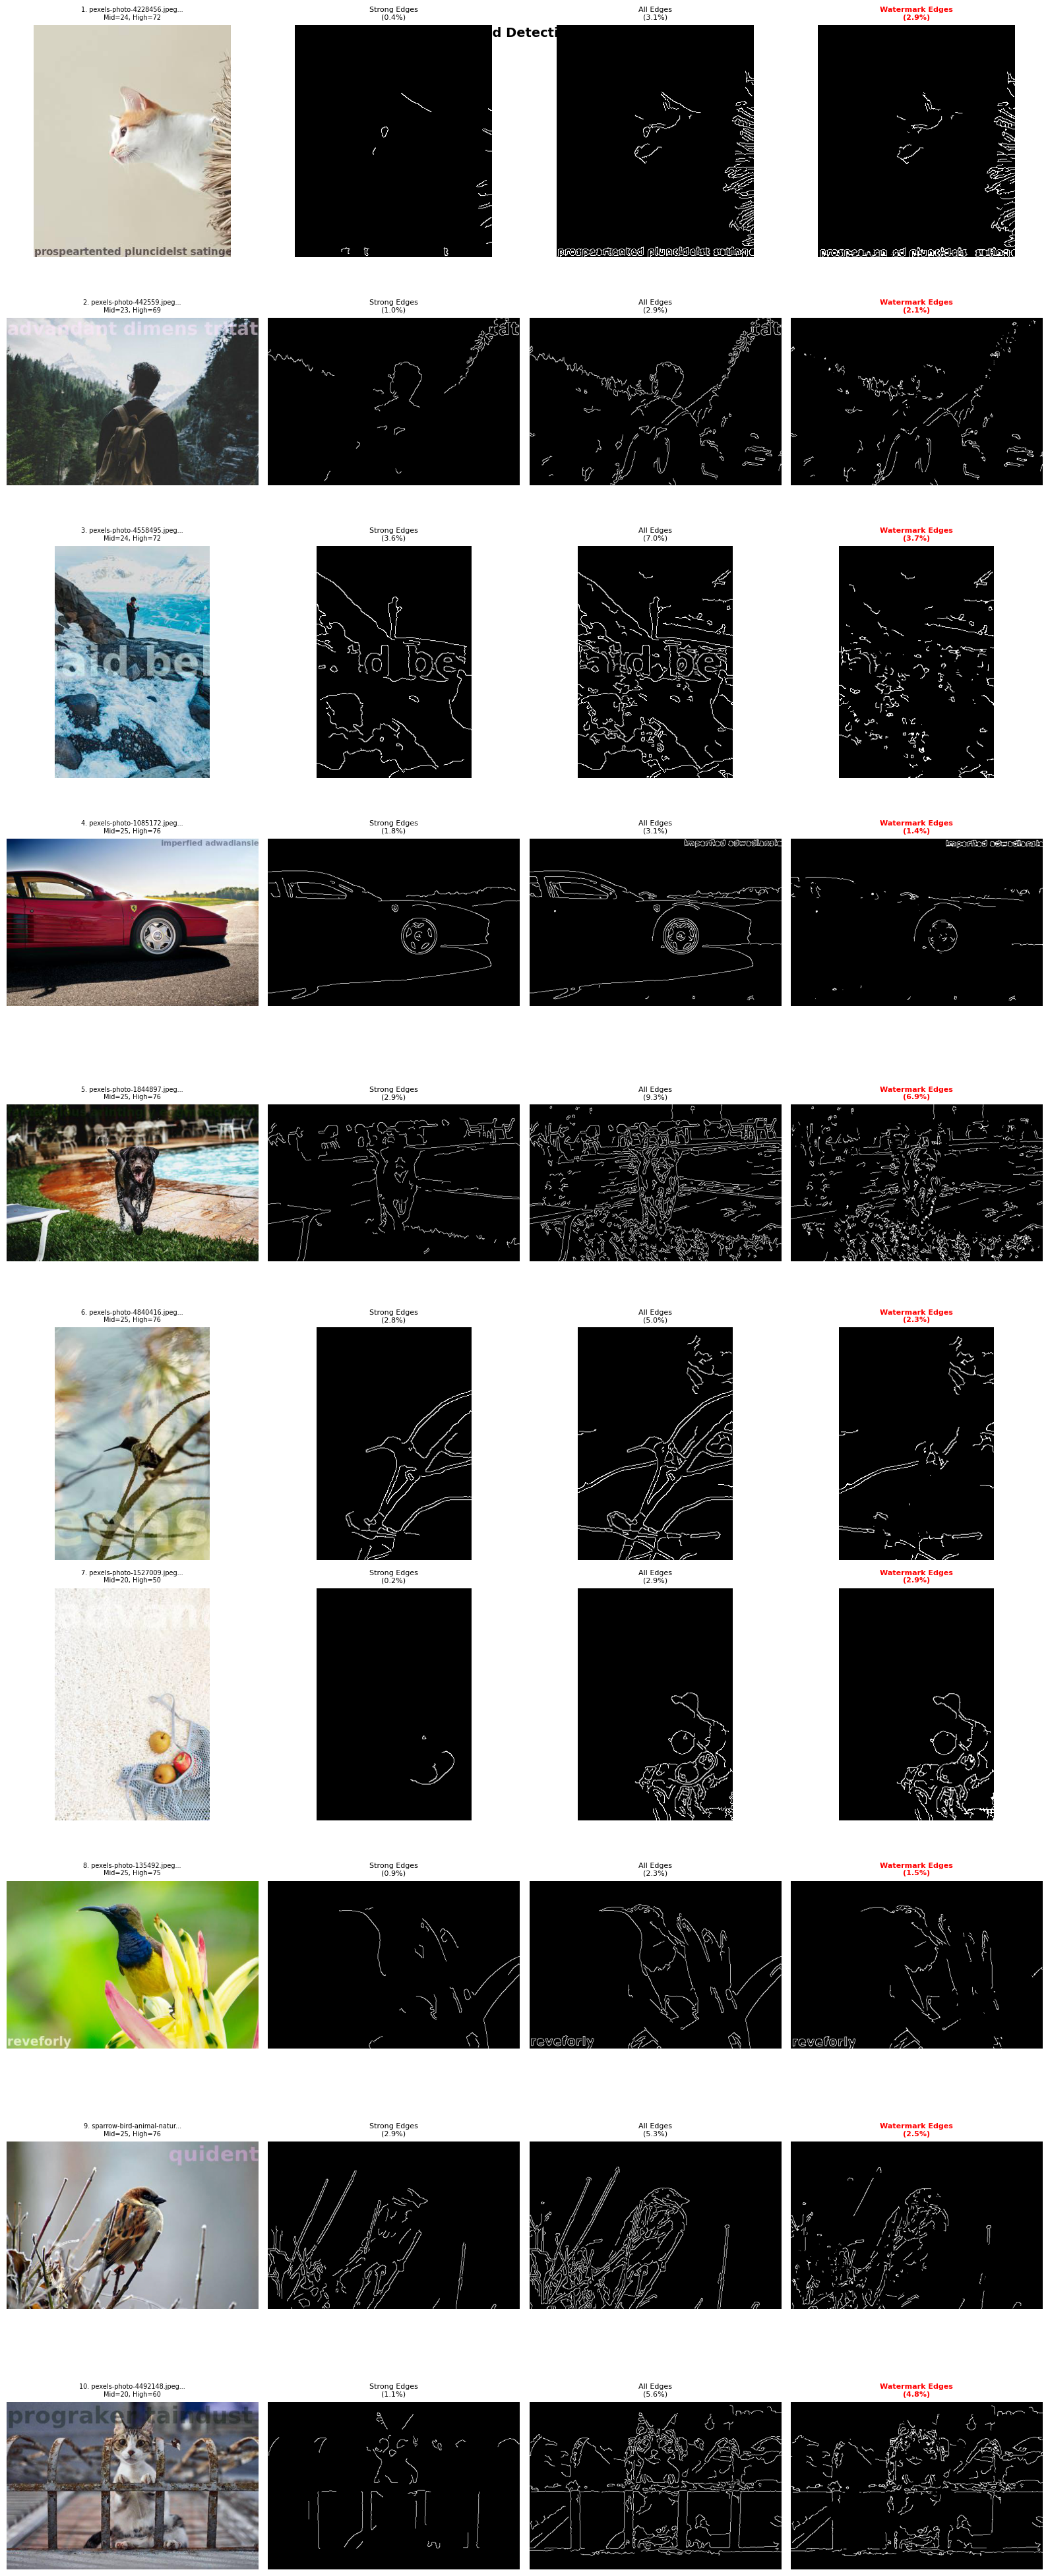


ADAPTIVE THRESHOLD RESULTS
Image                               Thresh (M/H)    Strong     All        Watermark
------------------------------------------------------------------------------------------
 1. pexels-photo-4228456.jpeg          24/ 72        0.43%     3.12%     2.93%
 2. pexels-photo-442559.jpeg           23/ 69        0.96%     2.88%     2.06%
 3. pexels-photo-4558495.jpeg          24/ 72        3.55%     6.95%     3.66%
 4. pexels-photo-1085172.jpeg          25/ 76        1.85%     3.13%     1.37%
 5. pexels-photo-1844897.jpeg          25/ 76        2.95%     9.27%     6.86%
 6. pexels-photo-4840416.jpeg          25/ 76        2.79%     4.97%     2.25%
 7. pexels-photo-1527009.jpeg          20/ 50        0.24%     2.92%     2.90%
 8. pexels-photo-135492.jpeg           25/ 75        0.86%     2.35%     1.54%
 9. sparrow-bird-animal-nature-8659    25/ 76        2.93%     5.30%     2.48%
10. pexels-photo-4492148.jpeg          20/ 60        1.07%     5.58%     4.82%
-------

In [168]:
# Visualize adaptive threshold results
fig, axes = plt.subplots(10, 4, figsize=(16, 40))

for idx, result in enumerate(adaptive_results):
    mid, high = result['thresholds']
    
    # Original image
    axes[idx, 0].imshow(result['img_rgb'])
    axes[idx, 0].set_title(f"{idx+1}. {result['filename'][:25]}...\nMid={mid}, High={high}", 
                          fontsize=7)
    axes[idx, 0].axis('off')
    
    # Strong edges
    axes[idx, 1].imshow(result['strong_edges'], cmap='gray')
    axes[idx, 1].set_title(f"Strong Edges\n({result['strong_density']:.1f}%)", fontsize=8)
    axes[idx, 1].axis('off')
    
    # All edges
    axes[idx, 2].imshow(result['all_edges'], cmap='gray')
    axes[idx, 2].set_title(f"All Edges\n({result['all_density']:.1f}%)", fontsize=8)
    axes[idx, 2].axis('off')
    
    # Watermark edges
    axes[idx, 3].imshow(result['watermark_edges'], cmap='gray')
    axes[idx, 3].set_title(f"Watermark Edges\n({result['watermark_density']:.1f}%)", 
                          fontsize=8, fontweight='bold', color='red')
    axes[idx, 3].axis('off')

plt.suptitle('Adaptive Dual-Threshold Detection (Max Ratio Method)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("ADAPTIVE THRESHOLD RESULTS")
print("="*90)
print(f"{'Image':<35} {'Thresh (M/H)':<15} {'Strong':<10} {'All':<10} {'Watermark'}")
print("-"*90)

for i, result in enumerate(adaptive_results, 1):
    mid, high = result['thresholds']
    print(f"{i:2d}. {result['filename'][:31]:<33} "
          f"{mid:3d}/{high:3d}      "
          f"{result['strong_density']:>6.2f}%   "
          f"{result['all_density']:>6.2f}%   "
          f"{result['watermark_density']:>6.2f}%")

print("-"*90)
print(f"{'AVERAGE':<35} {'varies':<15} "
      f"{np.mean([r['strong_density'] for r in adaptive_results]):>6.2f}%   "
      f"{np.mean([r['all_density'] for r in adaptive_results]):>6.2f}%   "
      f"{np.mean([r['watermark_density'] for r in adaptive_results]):>6.2f}%")
print("="*90)




## Comparison: Method 1 (MSER) vs Method 2 (SWT)

Compare the performance of both text detection methods



# Summary: Canny Edge Detection for Watermark Detection

Canny edge detection is a multi-stage algorithm that uses gradient calculations and dual thresholds to identify edges in images. I first applied basic Canny edge detection to the watermarked images, which successfully detected watermark edges but also captured all other edges in the image without discrimination. I hypothesized that watermark edges would be medium-strength edges—neither very strong nor very weak—due to the semi-transparent nature of watermarks. To isolate these medium-strength edges, I implemented a dual-threshold approach: performing Canny edge detection twice at different thresholds to separately capture strong edges (main content) and all significant edges (content plus watermark), then subtracting the strong edges from all edges to isolate the medium-strength edges that should correspond to the watermark. While this adaptive dual-threshold method successfully reduced false positives and isolated watermark-like edges in many images, it has notable limitations including sensitivity to watermark opacity variations, overlap with natural image edges of similar strength, and inability to leverage other distinguishing watermark properties such as color, spatial location, or text orientation. For production watermark detection systems, this approach would benefit from combination with additional signal processing techniques that exploit these complementary features.

